# Prophet을 이용한 울산 기온 예측

페이스북의 Prophet을 사용해서 기온을 예측 해보겠습니다.

## 라이브러리 불러오기

In [14]:
import os # 운영체제에서 제공되는 여러기능 수행하는 라이브러리
from prophet import Prophet # 인공지능
from datetime import datetime, timedelta # 시간 조작 라이브러리

# API 호출 및 응답결과 처리
import requests 
from urllib import parse
from bs4 import BeautifulSoup as bs

# 시각화
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd # 테이블 조작 라이브러리

In [2]:
# os.environ['ASOS_KEY'] = '서비스키'

In [38]:
# 오늘 날짜에서 2000년 1월 1일까지 차이
startdate = datetime(1996,11,1).strftime("%Y%m%d")
delta_time = datetime.today() - datetime(1996,11,1)

# 최대 호출 건수 999건 
max_count = 999

# 최대 호출건수에 딱 맞아 떨어지면 페이지 수는 몫, 그렇지 않으면 페이지 수는 몫 + 1
if (delta_time.days % max_count)==0:
    pageNo = delta_time.days // max_count
else:
    pageNo = delta_time.days // max_count
    pageNo += 1


# 오늘 날짜 YYYYDDMM 형식으로 today에 할당
today = datetime.today() + timedelta(days=-1)
today = today.strftime("%Y%m%d")

# API 인증키
serviceKey = os.environ['ASOS_KEY']

# 요청 변수
# 데이터 명세를 차분히 읽고 변수를 할당하면 됩니다.
params = {'serviceKey':parse.unquote(serviceKey), # encoding 된 API 인증키를 디코딩
          'dataCd':'ASOS',
          'dateCd':'DAY',
          'startDt':startdate, # 2000년 1월 1일 기온부터
          'endDt':today, # 현재 날짜 -1일 까지
          'numOfRows':'999',
          'pageNo':10,
          'stnIds':'152'} # 울산 지점번호

# 요청메시지에 들어가는 Call Back URL, 요청주소
url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

req = requests.get(url, params=params)
soup = bs(req.text,'lxml')

In [39]:
soup

<?xml version="1.0" encoding="UTF-8"?><html><body><response><header><resultcode>00</resultcode><resultmsg>NORMAL_SERVICE</resultmsg></header><datatype>XML</datatype><items><item><stnid>152</stnid><stnnm>울산</stnnm><tm>2021-06-14</tm><avgta>21.8</avgta><minta>19.8</minta><mintahrmt>527</mintahrmt><maxta>25.6</maxta><maxtahrmt>949</maxtahrmt><mi10maxrn></mi10maxrn><mi10maxrnhrmt></mi10maxrnhrmt><hr1maxrn></hr1maxrn><hr1maxrnhrmt></hr1maxrnhrmt><sumrndur></sumrndur><sumrn></sumrn><maxinsws>5.9</maxinsws><maxinswswd>90</maxinswswd><maxinswshrmt>1343</maxinswshrmt><maxws>4.2</maxws><maxwswd>90</maxwswd><maxwshrmt>1349</maxwshrmt><avgws>1.8</avgws><hr24sumrws>1573</hr24sumrws><maxwd>70</maxwd><avgtd>20.1</avgtd><minrhm>73</minrhm><minrhmhrmt>951</minrhmhrmt><avgrhm>90.9</avgrhm><avgpv>23.6</avgpv><avgpa>997.7</avgpa><maxps>1008.3</maxps><maxpshrmt>625</maxpshrmt><minps>1006.0</minps><minpshrmt>1757</minpshrmt><avgps>1007.0</avgps><ssdur>14.5</ssdur><sumsshr>5.6</sumsshr><hr1maxicsrhrmt></hr1m

In [37]:
delta_time.days

9142

In [34]:
pageNo

10

In [36]:
9142 % 999

151

In [4]:
# 첫번째 데이터
soup.find('item')

<item><stnid>152</stnid><stnnm>울산</stnnm><tm>2002-09-26</tm><avgta>19.7</avgta><minta>16.7</minta><mintahrmt>531</mintahrmt><maxta>23.9</maxta><maxtahrmt>1253</maxtahrmt><mi10maxrn></mi10maxrn><mi10maxrnhrmt></mi10maxrnhrmt><hr1maxrn></hr1maxrn><hr1maxrnhrmt></hr1maxrnhrmt><sumrndur></sumrndur><sumrn></sumrn><maxinsws>9.3</maxinsws><maxinswswd>90</maxinswswd><maxinswshrmt>1356</maxinswshrmt><maxws>6.1</maxws><maxwswd>90</maxwswd><maxwshrmt>1519</maxwshrmt><avgws>2.1</avgws><hr24sumrws>1814</hr24sumrws><maxwd>90</maxwd><avgtd>13.4</avgtd><minrhm>46</minrhm><minrhmhrmt>1518</minrhmhrmt><avgrhm>68.3</avgrhm><avgpv>15.4</avgpv><avgpa>1016.0</avgpa><maxps>1021.0</maxps><maxpshrmt>0</maxpshrmt><minps>1018.6</minps><minpshrmt>1604</minpshrmt><avgps>1019.9</avgps><ssdur>12.0</ssdur><sumsshr>7.5</sumsshr><hr1maxicsrhrmt></hr1maxicsrhrmt><hr1maxicsr></hr1maxicsr><sumgsr></sumgsr><ddmefs></ddmefs><ddmefshrmt></ddmefshrmt><ddmes></ddmes><ddmeshrmt></ddmeshrmt><sumdpthfhsc></sumdpthfhsc><avgtca>6.4

In [26]:
def append_dataframe(items_list,dataframe):
    for xml_tag in items_list:
        location = xml_tag.find('stnnm').text
        date = xml_tag.find('tm').text
        avg_temp = xml_tag.find('avgta').text

        value_dict = {'location':location,
                      'date':date,
                      'avg_temp':avg_temp}
        dataframe = dataframe.append(value_dict,ignore_index=True)
        
    return dataframe

In [54]:
# 오늘 날짜에서 2000년 1월 1일까지 차이
startdate = datetime(1996,11,1).strftime("%Y%m%d")
delta_time = datetime.today() - datetime(1996,11,1)

# 최대 호출 건수 999건 
max_count = 999

# 최대 호출건수에 딱 맞아 떨어지면 페이지 수는 몫, 그렇지 않으면 페이지 수는 몫 + 1
if (delta_time.days % max_count)==0:
    pageNo = delta_time.days // max_count
else:
    pageNo = delta_time.days // max_count
    pageNo += 1


# 오늘 날짜 YYYYDDMM 형식으로 today에 할당
today = datetime.today() + timedelta(days=-1)
today = today.strftime("%Y%m%d")

# API 인증키
serviceKey = os.environ['ASOS_KEY']


dataframe = pd.DataFrame(columns=['location','date','avg_temp'])

for i in tqdm(range(1,pageNo+1)):
    
#     if i == pageNo:
#         numOfRows = delta_time.days % max_count
#     else:
#         numOfRows = max_count
        
    params = {'serviceKey':parse.unquote(serviceKey), # encoding 된 API 인증키를 디코딩
              'dataCd':'ASOS',
              'dateCd':'DAY',
              'startDt':startdate, # 2000년 1월 1일 기온부터
              'endDt':today, # 현재 날짜 -1일 까지
              'numOfRows':max_count,
              'pageNo':i,
              'stnIds':'152'} # 울산 지점번호

    # 요청메시지에 들어가는 Call Back URL, 요청주소
    url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

    req = requests.get(url, params=params)
    soup = bs(req.text,'lxml')
    item = soup.find_all('item')
    dataframe = append_dataframe(item,dataframe)

100%|██████████| 10/10 [01:55<00:00, 11.54s/it]


In [51]:
pageNo

10

In [33]:
for i in dataframe.query('date >= "2018-08-01"')['date']:
    print(i)

2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-06
2018-01-07
2018-01-08
2018-01-09
2018-01-10
2018-01-11
2018-01-12
2018-01-13
2018-01-14
2018-01-15
2018-01-16
2018-01-17
2018-01-18
2018-01-19
2018-01-20
2018-01-21
2018-01-22
2018-01-23
2018-01-24
2018-01-25
2018-01-26
2018-01-27
2018-01-28
2018-01-29
2018-01-30
2018-01-31
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
2018-02-28
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
2018-03-31
2018-04-01

In [55]:
for i in dataframe.query('date >= "2018-08-01"')['date']:
    print(i)

2018-08-01
2018-08-02
2018-08-03
2018-08-04
2018-08-05
2018-08-06
2018-08-07
2018-08-08
2018-08-09
2018-08-10
2018-08-11
2018-08-12
2018-08-13
2018-08-14
2018-08-15
2018-08-16
2018-08-17
2018-08-18
2018-08-19
2018-08-20
2018-08-21
2018-08-22
2018-08-23
2018-08-24
2018-08-25
2018-08-26
2018-08-27
2018-08-28
2018-08-29
2018-08-30
2018-08-31
2018-09-01
2018-09-02
2018-09-03
2018-09-04
2018-09-05
2018-09-06
2018-09-07
2018-09-08
2018-09-09
2018-09-10
2018-09-11
2018-09-12
2018-09-13
2018-09-14
2018-09-15
2018-09-16
2018-09-17
2018-09-18
2018-09-19
2018-09-20
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-25
2018-09-26
2018-09-27
2018-09-28
2018-09-29
2018-09-30
2018-10-01
2018-10-02
2018-10-03
2018-10-04
2018-10-05
2018-10-06
2018-10-07
2018-10-08
2018-10-09
2018-10-10
2018-10-11
2018-10-12
2018-10-13
2018-10-14
2018-10-15
2018-10-16
2018-10-17
2018-10-18
2018-10-19
2018-10-20
2018-10-21
2018-10-22
2018-10-23
2018-10-24
2018-10-25
2018-10-26
2018-10-27
2018-10-28
2018-10-29
2018-10-30

In [56]:
dataframe

,location,date,avg_temp
0,울산,1996-11-01,14.9
1,울산,1996-11-02,13.5
2,울산,1996-11-03,12.9
3,울산,1996-11-04,14.1
4,울산,1996-11-05,17.2
...,...,...,...
9137,울산,2021-11-07,16.8
9138,울산,2021-11-08,13.8
9139,울산,2021-11-09,9.1
9140,울산,2021-11-10,9.3


In [48]:
len(dataframe.drop_duplicates(subset=['date']))

8991

In [49]:
9142/999

9.15115115115115

In [50]:
999*9

8991

In [57]:
dataframe.to_csv('ulsan_temp_19961101_20211111.csv')

In [8]:
after_process_df = dataframe.drop(columns=['location'])
after_process_df = after_process_df.rename(columns={'date':'ds','avg_temp':'y'})
after_process_df['ds'] = pd.to_datetime(after_process_df['ds'])
after_process_df['y'] = pd.to_numeric(after_process_df['y'])

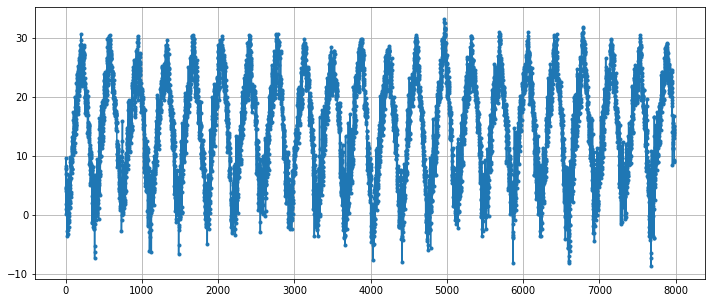

In [15]:
after_process_df["y"].plot(figsize=(12, 5), style='.-', grid=True);

In [10]:
after_process_df

,ds,y
0,2000-01-01,7.0
1,2000-01-02,8.3
2,2000-01-03,4.4
3,2000-01-04,4.6
4,2000-01-05,7.8
...,...,...
7981,2021-11-07,16.8
7982,2021-11-08,13.8
7983,2021-11-09,9.1
7984,2021-11-10,9.3


In [11]:
model = Prophet()
model.fit(after_process_df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,14.455362,-1.308915,5.800985,14.455362,14.455362,-12.000302,-12.000302,-12.000302,0.030717,0.030717,0.030717,-12.031019,-12.031019,-12.031019,0.0,0.0,0.0,2.455061
1,2000-01-02,14.455477,-1.000497,6.156089,14.455477,14.455477,-11.999848,-11.999848,-11.999848,0.076524,0.076524,0.076524,-12.076371,-12.076371,-12.076371,0.0,0.0,0.0,2.455629
2,2000-01-03,14.455591,-0.926618,5.762043,14.455591,14.455591,-12.056935,-12.056935,-12.056935,0.059248,0.059248,0.059248,-12.116184,-12.116184,-12.116184,0.0,0.0,0.0,2.398656
3,2000-01-04,14.455705,-1.438459,5.788804,14.455705,14.455705,-12.156763,-12.156763,-12.156763,-0.006033,-0.006033,-0.006033,-12.150730,-12.150730,-12.150730,0.0,0.0,0.0,2.298942
4,2000-01-05,14.455819,-1.368176,5.958054,14.455819,14.455819,-12.264836,-12.264836,-12.264836,-0.084525,-0.084525,-0.084525,-12.180311,-12.180311,-12.180311,0.0,0.0,0.0,2.190983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8346,2022-11-07,14.714103,9.050187,16.231487,14.677009,14.744861,-2.033932,-2.033932,-2.033932,0.059248,0.059248,0.059248,-2.093180,-2.093180,-2.093180,0.0,0.0,0.0,12.680171
8347,2022-11-08,14.714076,8.689774,15.822620,14.676832,14.744859,-2.310857,-2.310857,-2.310857,-0.006033,-0.006033,-0.006033,-2.304825,-2.304825,-2.304825,0.0,0.0,0.0,12.403218
8348,2022-11-09,14.714049,8.498839,15.752266,14.676656,14.745111,-2.605144,-2.605144,-2.605144,-0.084525,-0.084525,-0.084525,-2.520619,-2.520619,-2.520619,0.0,0.0,0.0,12.108905
8349,2022-11-10,14.714022,8.315646,15.482527,14.676479,14.745313,-2.768762,-2.768762,-2.768762,-0.028200,-0.028200,-0.028200,-2.740562,-2.740562,-2.740562,0.0,0.0,0.0,11.945260


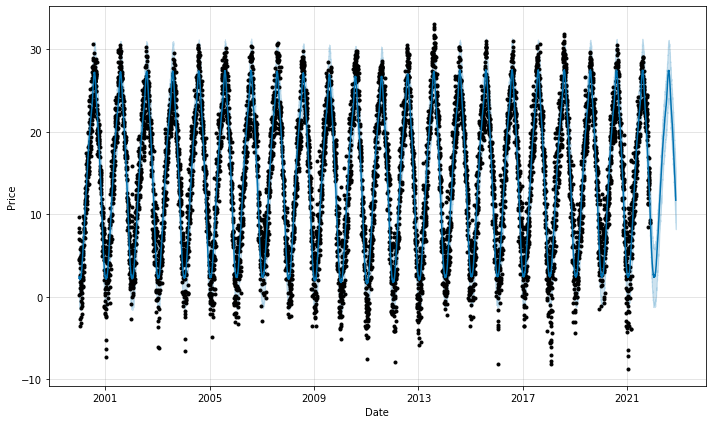

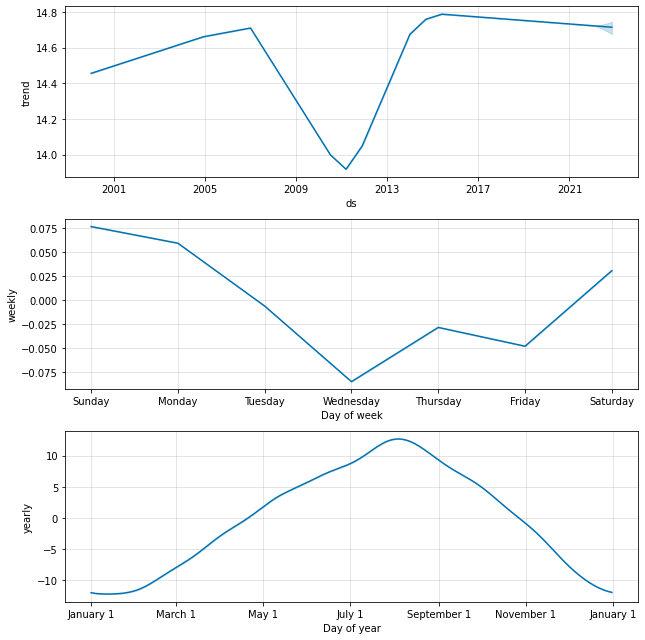

In [16]:
model.plot(forecast, xlabel='Date', ylabel='Price')
model.plot_components(forecast)
plt.show()